# SCQC Thailand 2023 - Introduction to Qiskit Primitives and Qiskit Runtime
Presented by: Astri Cornish

This tutorial was adapted from pre-existing notebooks. Credit to:  
- _Abby Mitchell_ - Quantum Developer Advocate (https://abbymitchell.dev)  
- _Vishal Bajpe_ - Quantum Community Developer Advocate (https://github.com/mrvee-qC)
- IBM Quantum and Qiskit tutorial documentations (https://qiskit.org/documentation/tutorials.html)

### Parametric Circuits - Great for Variational Algorithms and thus Quantum Machine Learning!

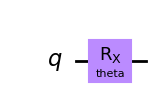

In [2]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.circuit import Parameter
import numpy as np

# Define a variable theta to be a parameter with name 'theta'
theta = Parameter('theta')

# Initialize a quantum circuit with one qubit
quantum_circuit = QuantumCircuit(1)

# Add a parametrized RX rotation on the qubit
quantum_circuit.rx(theta, 0)

quantum_circuit.draw(output="mpl")

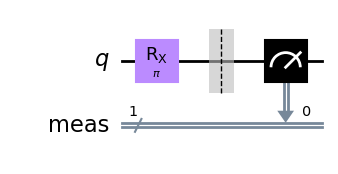

In [24]:
# Set the value of the parameter
theta_value = np.pi

# Bind the value to the parametrized circuit
qc = quantum_circuit.bind_parameters({theta: theta_value})

# Add a measurement gate to the circuit before we run it
qc.measure_all()

qc.draw(output="mpl")

In [25]:
# Running on a simulator
from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc) # shots = 1024 is the default
result = job.result() 
counts = result.get_counts() 
counts

{'1': 1024}

In [9]:
# running on a quantum device

from qiskit import transpile
from qiskit_ibm_provider import IBMProvider, least_busy

provider = IBMProvider(instance='ibm-q/open/main')

# get the least-busy backend 
real_backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 1 and
                                   not b.configuration().simulator and b.status().operational==True))

print(f"The best backend is: ", real_backend.name)


# transpilation
circuit_transpiled = transpile(qc, real_backend)

# submit the job
job = real_backend.run(circuit_transpiled, shots = 1024)

# Monitoring our job
from qiskit_ibm_provider.job import job_monitor
print(f"Job ID: {job.job_id()}")
job_monitor(job)

results = job.result()
counts = results.get_counts()
counts

The best backend is: ibmq_quito
Job ID: chr9df1vrup89877810g
Job Status: job has successfully run


{'0': 12, '1': 1012}

What about when I need to try different values for theta for the same circuit (an important concept for quantum machine learning)?  
Will I have to re-submit the circuit and wait in a queue every time I want to try a different theta value?!  
Can I do this in a more efficient way?

## Qiskit Runtime and Qiskit Primitives - New(ish) Features 🎉

![](circuit_flow.png)

![](runtime_prog_flow.png)

![](primitives.png)

![](sampler_estimator.png)


#### Simple Sampler Example

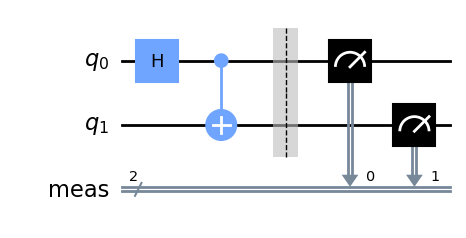

In [4]:
from qiskit import QuantumCircuit
bell = QuantumCircuit(2)
bell.h(0)
bell.cx(0, 1)
bell.measure_all()
bell.draw()

SamplerResult(quasi_dists=[{0: 0.51, 3: 0.49}], metadata=[{'shots': 100}])
Quasi-distribution is:  {'00': 0.51, '11': 0.49}


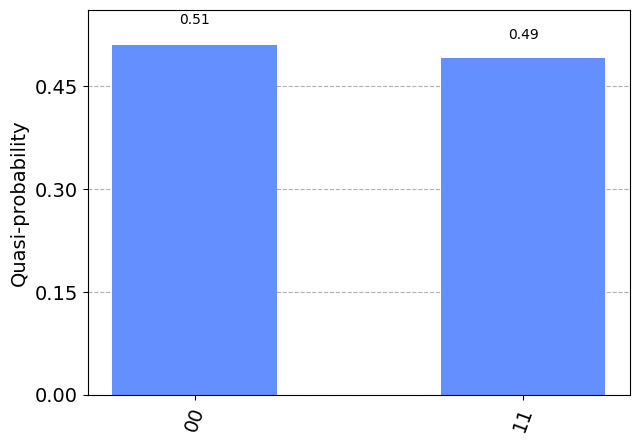

In [5]:
from qiskit.primitives import Sampler

sampler = Sampler(options={"shots": 100})
job = sampler.run(bell) # uses local simulator under the hood
result = job.result()

print(result)

# quasi-distribution:
dist = result.quasi_dists[0].binary_probabilities()
print(f"Quasi-distribution is: ", dist)

plot_histogram(dist)

#### Sampler example attempting multiple thetas with the same circuit

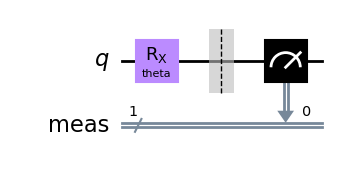

In [6]:
quantum_circuit.measure_all()
quantum_circuit.draw()
#notice that theta is an unbound parameter

In [7]:
thetas = [0, np.pi/4, np.pi/3, np.pi/2, 2*np.pi/3, 3*np.pi/4, np.pi]

indv_thetas = [[ph] for ph in thetas] #[[0], [np.pi/4], [np.pi/3], [np.pi/2], [2*np.pi/3], [3*np.pi/4], [np.pi]]

job = sampler.run([quantum_circuit]*len(indv_thetas), parameter_values=indv_thetas) # uses local simulator under the hood
result = job.result()

quasi_dists = result.quasi_dists
quasi_dists

[{0: 1.0},
 {0: 0.84, 1: 0.16},
 {0: 0.67, 1: 0.33},
 {0: 0.55, 1: 0.45},
 {0: 0.24, 1: 0.76},
 {0: 0.15, 1: 0.85},
 {1: 1.0}]

In [8]:
# Get the prob values for each of the states

prob_values_0 = [dist.get(0, 0) for dist in result.quasi_dists]
prob_values_1 = [dist.get(1, 0) for dist in result.quasi_dists]

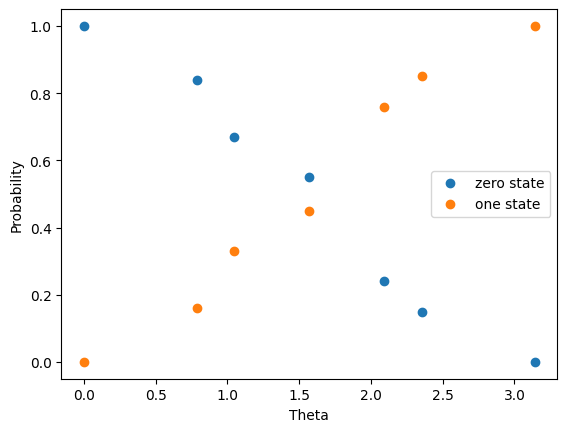

In [9]:
import matplotlib.pyplot as plt

plt.plot(thetas, prob_values_0, 'o', label='zero state')
plt.plot(thetas, prob_values_1, 'o', label='one state')
plt.xlabel('Theta')
plt.ylabel('Probability')
plt.legend();

#### Use Primitives with IBM Devices via Sessions - (Alpha: Still under active development)

If you want to get results from IBM hardware using primitives, you need to use the `qiskit_ibm_runtime` provider, which facilitates the connection to the IBM hardware via sessions.

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler
from qiskit import QuantumCircuit

# QiskitRuntimeService.save_account(channel='ibm_quantum', token='my_token', overwrite=True) #uncomment if you need to save your account again
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
)

print(service.backends())

real_backend = service.least_busy(min_num_qubits=2, simulator=False, operational=True)

print(f"The best backend is {real_backend.name}")

# backend = service.get_backend('ibmq_qasm_simulator') # simulator
# can also use noisy simulators

# Execute both example circuits
with Session(service=service, backend=real_backend) as session:
    sampler = Sampler(session=session)

    # now we can run multiple jobs but only queue once
    job = sampler.run([bell], [[]])
    samples_bell = job.result().quasi_dists[0]

    job = sampler.run([quantum_circuit]*len(indv_thetas), parameter_values=indv_thetas)
    samples_param = job.result().quasi_dists

[<IBMBackend('ibmq_lima')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('ibm_lagos')>, <IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('ibmq_quito')>, <IBMBackend('ibmq_belem')>, <IBMBackend('simulator_statevector')>, <IBMBackend('ibmq_manila')>, <IBMBackend('ibm_nairobi')>, <IBMBackend('ibm_perth')>, <IBMBackend('ibmq_jakarta')>]
The best backend is ibmq_lima


In [13]:
samples_bell.binary_probabilities()

{'00': 0.5153231178878536,
 '01': 0.00306419655209239,
 '10': 0.003709545428729359,
 '11': 0.4779031401313247}

In [8]:
samples_param

[{0: 0.9969182548697884, 1: 0.0030817451302116265},
 {0: 0.8683369094198327, 1: 0.13166309058016745},
 {0: 0.7797235895494131, 1: 0.22027641045058688},
 {0: 0.5386006983886575, 1: 0.4613993016113425},
 {0: 0.27723084690142624, 1: 0.7227691530985737},
 {0: 0.17389246497538813, 1: 0.8261075350246118},
 {0: 0.0013988808952838223, 1: 0.9986011191047162}]

In [14]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright